In [1]:
# gesture_recog.ipynb

# The model is to train the guesture of images with the Leap Motion 
# T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared 
# Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision
# Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)

# Please download the leapgestrecog dataset from Kaggle. 
# https://www.kaggle.com/gti-upm/leapgestrecog

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt
from alexnet import AlexNet
from keras.preprocessing import image

import numpy as np
import datetime
import os
import shutil
from PIL import Image
from numba import cuda

In [3]:
# Set up the GPU growth to avoid the sudden runtime error.

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Move the iamges from the original path to the source path 

orig_dir = '/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog'
src_dir  = '/home/mike/Documents/image_gesture/leapgestrecog/src_data'
if not os.path.exists(src_dir):
    os.makedirs(src_dir)

def move_data(orig_dir, src_dir):

    # Conduct three iterations with i, j and k counters
    for i in os.listdir(orig_dir):
        label = 0
        # Get the original category(ca) with i pointing to any folder from 00 to 09
        origca_dir = os.path.join(orig_dir, i)
        print("[INFO]Category：%s %s"% (origca_dir,i))
        
        # The counter j points to any folder from 01_palm to 10_down. 
        for j in os.listdir(origca_dir):
            # The label is related to str(label) in the k iterations. 
            label = label + 1
            # Create the origcaty_dir.Type(ty) represents the type of the above folders
            origcaty_dir = os.path.join(origca_dir, j)
            print("[INFO]Type：%s %s"% (origcaty_dir,j))
            
            for k in os.listdir(origcaty_dir):
                # origimg_path is the absolute path that holds the images such as frame_00_7_0001.png
                origimg_path = os.path.join(origcaty_dir, k)
                # Create the diretort for the label with str(label) ranging from 1 to 10
                srclbl_dir = os.path.join(src_dir, str(label))
                if not os.path.exists(srclbl_dir):
                    os.makedirs(srclbl_dir)
                # Create the absolute path 
                srcimg_path = os.path.join(srclbl_dir, k)
                 # Move the images 
                shutil.move(origimg_path, srcimg_path)
                
        print("[INFO]One Person Finished：", origcaty_dir)
        
    print("[INFO]All Finished!")

move_data(orig_dir, src_dir)

[INFO]Category：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06 06
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/03_fist 03_fist
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/04_fist_moved 04_fist_moved
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/08_palm_moved 08_palm_moved
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/02_l 02_l
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/06_index 06_index
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/05_thumb 05_thumb
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/10_down 10_down
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/01_palm 01_palm
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/09_c 09_c
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/lea

In [5]:
# Divide the dataset into train, validation and test sets. 

# Designate source and division datasets
src_dir = '/home/mike/Documents/image_gesture/leapgestrecog/src_data'
dset_dir = '/home/mike/Documents/image_gesture/dset_data'
if not os.path.exists(dset_dir):
    os.makedirs(dset_dir)

if not os.path.exists(dset_dir):
    os.makedirs(dset_dir)

# Make three directories for training, validation and test
train_dir = os.path.join(dset_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
val_dir = os.path.join(dset_dir, 'validation')
if not os.path.exists(val_dir):
    os.mkdir(val_dir)  

test_dir = os.path.join(dset_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

    
for num in os.listdir(src_dir):
    # Folder 1~10
    train_idx_dir = os.path.join(train_dir, num)
    if not os.path.exists(train_idx_dir):
        os.mkdir(train_idx_dir)
        
    val_idx_dir = os.path.join(val_dir, num)
    if not os.path.exists(val_idx_dir):
        os.mkdir(val_idx_dir)
        
    test_idx_dir = os.path.join(test_dir, num)
    if not os.path.exists(test_idx_dir):
        os.mkdir(test_idx_dir)
        
    # Index is increasing. 
    src_idx_dir = os.path.join(src_dir, num)
    
    # print(src_idx_dir)

    j = 0
    
    for fname in os.listdir(src_idx_dir): 
        
        if j < 1000:  # Copy 1000 images to the train directory
            src = os.path.join(src_idx_dir, fname)
            dst = os.path.join(train_idx_dir, fname)
            shutil.copyfile(src, dst)
        elif (j >= 1000 and j < 1500):  # Copy 500 images to the val directory
            src = os.path.join(src_idx_dir, fname)
            dst = os.path.join(val_idx_dir, fname)
            shutil.copyfile(src, dst)
        elif (j >= 1500):  # Copy 500 images to the test directory
            src = os.path.join(src_idx_dir, fname)
            dst = os.path.join(test_idx_dir, fname)
            shutil.copyfile(src, dst)
            
        j = j + 1
        
    print("[INFO]Copy finished! :", train_idx_dir)
    print("[INFO]Copy finished! :", val_idx_dir)
    print("[INFO]Copy finished! :", test_idx_dir)


print('[INFO]training files:', len(os.listdir(train_dir)))
print('[INFO]validation files:', len(os.listdir(val_dir)))
print('[INFO]test files:', len(os.listdir(test_dir)))

print('[INFO]1 training images:', len(os.listdir(train_dir+"/1/")))
print('[INFO]1 validation images:', len(os.listdir(val_dir+"/1/")))
print('[INFO]1 test images:', len(os.listdir(test_dir+"/1/")))

[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/train/9
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/validation/9
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/test/9
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/train/2
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/validation/2
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/test/2
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/train/4
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/validation/4
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/test/4
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/train/7
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/validation/7
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/test/7
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/trai

In [6]:
# Assign the global arguments 

EPOCHS = 32
BATCH_SIZE = 64
image_width = 227
image_height = 227
channels = 3
num_classes = 1

In [7]:
# Call the cnn/alexnet model 

model = AlexNet((image_width,image_height,channels), num_classes)

In [8]:
# Model configuration

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

In [9]:
# Summary

model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       884

In [10]:
# Preprocess the images

train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_width,image_height),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')
train_num = train_generator.samples


val_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(image_width,image_height),
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary')

val_num = val_generator.samples


test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(image_width,image_height),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary')

test_num = test_generator.samples

Found 10000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [11]:
# Get the batch shape

for data_batch, label_batch in train_generator:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", label_batch)
    
    break

data batch shape: (64, 227, 227, 3)
labels batch shape: [5. 6. 8. 9. 0. 0. 0. 2. 4. 9. 8. 8. 5. 1. 3. 4. 2. 1. 4. 6. 9. 0. 9. 5.
 5. 7. 3. 8. 8. 6. 6. 3. 9. 9. 1. 0. 0. 5. 9. 5. 5. 7. 3. 1. 6. 0. 0. 3.
 9. 3. 8. 9. 8. 6. 3. 8. 2. 0. 7. 6. 4. 7. 8. 5.]


In [12]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_num//BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=val_generator,
                    validation_steps=val_num//BATCH_SIZE)

Epoch 1/32
156/156 [==============================] - 28s 182ms/step - loss: -53.3386 - acc: 0.1002 - val_loss: -53.3571 - val_acc: 0.1002
Epoch 2/32
156/156 [==============================] - 28s 178ms/step - loss: -53.3586 - acc: 0.1002 - val_loss: -53.3815 - val_acc: 0.0998
Epoch 3/32
156/156 [==============================] - 28s 177ms/step - loss: -53.3861 - acc: 0.0999 - val_loss: -53.3662 - val_acc: 0.1002
Epoch 4/32
156/156 [==============================] - 28s 177ms/step - loss: -53.4291 - acc: 0.0998 - val_loss: -53.3998 - val_acc: 0.1002
Epoch 5/32
156/156 [==============================] - 28s 177ms/step - loss: -53.3048 - acc: 0.0999 - val_loss: -53.3693 - val_acc: 0.1000
Epoch 6/32
156/156 [==============================] - 28s 177ms/step - loss: -53.3892 - acc: 0.0997 - val_loss: -53.3601 - val_acc: 0.0998
Epoch 7/32
156/156 [==============================] - 28s 177ms/step - loss: -53.4844 - acc: 0.1001 - val_loss: -53.3571 - val_acc: 0.1000
Epoch 8/32
156/156 [=======

In [13]:
# Save the model 

model.save('/home/mike/Documents/image_gesture/leapGestRecog_small_1.h5')
model.save('/home/mike/Documents/image_gesture/leapGestRecog_small_2.h5')

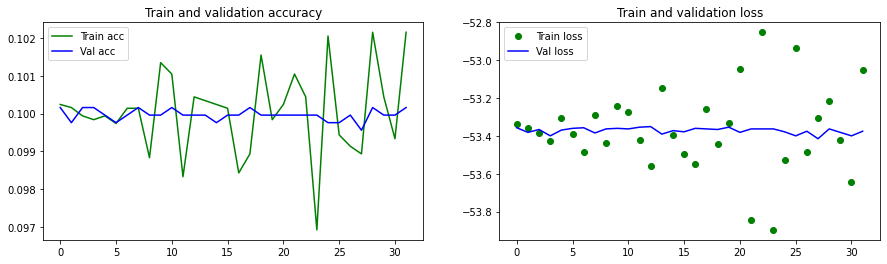

In [14]:
# Evaluate the model with visulizing the result 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Train acc', color='green')
plt.plot(epochs, val_acc, 'b', label='Val acc')
plt.title('Train and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Train loss', color='green')
plt.plot(epochs, val_loss, 'b', label='Val loss')
plt.title('Train and validation loss')
plt.legend()

plt.show()

In [15]:
# Release the GPU memory 

cuda.select_device(0)
cuda.close()